In [338]:
%pylab inline
import os, csv
import operator

Populating the interactive namespace from numpy and matplotlib


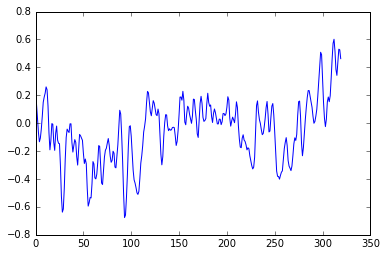

In [339]:
data_to_charge = 0 # 0 is for the music samples, 1 is for TIMIT
if data_to_charge not in (0, 1):
    raise ValueError("data_to_charge must be 0 (music) or 1 (speech)")
elif data_to_charge == 0:
    data_folder = "../sample/"
else:
    data_folder = "../timit"

files_names = (os.listdir(data_folder))
folder_size = len(files_names)
sample_lenght = 0

cr = csv.reader(open(data_folder + files_names[0], "r"))
for row in cr:
    sample_lenght += 1

data = np.zeros((folder_size, sample_lenght, 2))
    
for file_number, file in enumerate(files_names):
    cr = csv.reader(open(data_folder + file, "r"))
    for row_number, row in enumerate(cr):
        data[file_number][row_number] = [float(row[0]), float(row[1])]
        
plot(data[4][:,0])

In [340]:
class RNNNumpy:
    
    def __init__(self, word_dim, hidden_dim=10, bptt_truncate=4):
        # Assign instance variables
        self.word_dim = word_dim
        self.hidden_dim = hidden_dim
        self.bptt_truncate = bptt_truncate
        # Randomly initialize the network parameters
        self.V = np.random.normal(0, 0.1, (word_dim, hidden_dim))
        self.W = np.random.normal(0, 0.1, (hidden_dim, hidden_dim))
        


In [341]:
def forward_propagation(self, size, initialState):
    # The total number of time steps
    T = size
    # During forward propagation we save all hidden states in s because need them later.
    s = np.zeros((T , self.hidden_dim))
    s[-1] = np.ones( self.hidden_dim)*initialState
    # The outputs at each time step. Again, we save them for later.
    o = np.zeros((T, self.word_dim))
    # For each time step...
    for t in np.arange(T):
        s[t] = np.tanh(self.W.dot(s[t-1]))
        o[t] = np.tanh(self.V.dot(s[t]))
    return [o, s]

RNNNumpy.forward_propagation = forward_propagation

In [342]:
def predict(self, x):
    # Perform forward propagation and return index of the highest score
    o, s = self.forward_propagation(len(x), x[0])
    return o

RNNNumpy.predict = predict

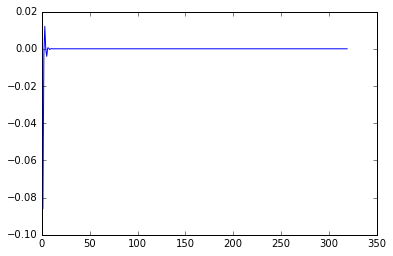

In [343]:
model = RNNNumpy(1, hidden_dim=31)
X_train = data[4][:,0]
#X_train = np.ones(320)
o = model.predict(X_train)
plot(o)

In [344]:
def calculate_loss(self, x):
    o, s = self.forward_propagation(len(x), x[1])
    o=o.reshape(x.shape)
    return ((x-o)*(x-o)).sum()
RNNNumpy.calculate_loss=calculate_loss

In [345]:
loss = model.calculate_loss( X_train)
loss

17.649754134429635

In [346]:
def bptt(self, y):
    T = len(y)
    # Perform forward propagation
    o, s = self.forward_propagation(len(y), y[0])
    # We accumulate the gradients in these variables
    dLdV = np.zeros(self.V.shape)
    dLdW = np.zeros(self.W.shape)
    delta_o = (o - y)**2
    #delta_o[np.arange(len(x)), x] -= 1.
    # For each output backwards...
    for t in np.arange(T)[::-1]:
        #dLdV += np.outer(delta_o[t], s[t].T)
        delta_out_t = (y[t]-o[t])*(1-o[t]**2)
        dLdV += delta_t*s[t]
        # Initial delta calculation
        #delta_t = self.V.T.dot(delta_o[t]) * (1 - (s[t] ** 2))
        # Backpropagation through time (for at most self.bptt_truncate steps)
        for bptt_step in np.arange(max(0, t-self.bptt_truncate), t+1)[::-1]:
            # print "Backpropagation step t=%d bptt step=%d " % (t, bptt_step)
            # dLdW += np.outer(delta_t, s[bptt_step-1])              
            # Update delta for next step
            # delta_t = self.W.T.dot(delta_t) * (1 - s[bptt_step-1] ** 2)
            delta_t= self.W.dot(delta_t)* (1 - np.tanh(s[bptt_step]) ** 2)
            dLdW += delta_t*s[bptt_step-1]
    return [dLdV, dLdW]

RNNNumpy.bptt = bptt

In [347]:
def bptt2(self, y):
    T = len(y)
    # Perform forward propagation
    o, s = self.forward_propagation(len(y), y[0])
    # We accumulate the gradients in these variables
    dLdV = np.zeros(self.V.shape)
    dLdW = np.zeros(self.W.shape)
    delta_o = np.zeros(T)
    delta  = np.zeros((T,self.hidden_dim))
    # For each output backwards...
    delta_o[T-1] = (y[T-1]-o[T-1])*(1-o[T-1]**2)
    delta[T-1] = (delta_o[T-1]*self.W).sum(1) *(1- np.tanh(s[T-1])**2)
    dLdV += delta_o[T-1]*s[T-1]
    #TODO opti ?
    dLdW += delta[T-1]*s[T-2]
    for t in np.arange(T-1)[::-1]:
        #dLdV += np.outer(delta_o[t], s[t].T)
        delta_o[t] = (y[t]-o[t])*(1-o[t]**2)
        delta[t] = (self.W.dot(delta[t+1]) + self.V.dot(delta_o[t]))*(1- np.tanh(s[t])**2)
        dLdV += delta_o[t]*s[t]
        if(t>0):
            dLdW += delta[t]*s[t-1]
    return [dLdV, dLdW]

RNNNumpy.bptt = bptt2

In [348]:
# Performs one step of SGD.
def numpy_sdg_step(self, x, learning_rate):
    # Calculate the gradients
    dLdV, dLdW = self.bptt(x)
    # Change parameters according to gradients and learning rate
    self.V += learning_rate * dLdV
    self.W += learning_rate * dLdW

RNNNumpy.sgd_step = numpy_sdg_step

In [349]:
# Outer SGD Loop
# - model: The RNN model instance
# - x: séquence to generate
# - learning_rate: Initial learning rate for SGD
# - nepoch: Number of times to iterate through the complete dataset
def train_with_sgd(model, x, learning_rate=0.0003, nepoch=100):
    # We keep track of the losses so we can plot them later
    losses = []
    for epoch in range(nepoch):
        # One SGD step
        loss = model.calculate_loss(x)
        losses.append(loss)
        model.sgd_step(x, learning_rate)
        
    return losses
 

In [350]:
losses = train_with_sgd(model, X_train, nepoch=1000, learning_rate=0.0001)

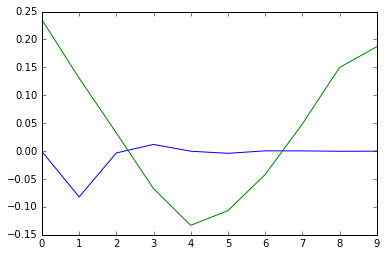

In [353]:

o = model.predict(X_train)
plot(o[:10])
plot(X_train[:10])

[17.649754134429635,
 17.649749850551345,
 17.649745566963553,
 17.649741283666231,
 17.649737000659353,
 17.649732717942896,
 17.649728435516831,
 17.649724153381133,
 17.649719871535776,
 17.649715589980737,
 17.649711308715986,
 17.649707027741503,
 17.649702747057255,
 17.649698466663221,
 17.649694186559373,
 17.649689906745689,
 17.649685627222137,
 17.649681347988697,
 17.649677069045342,
 17.649672790392046,
 17.649668512028782,
 17.649664233955523,
 17.649659956172247,
 17.649655678678929,
 17.649651401475538,
 17.649647124562048,
 17.649642847938441,
 17.649638571604687,
 17.649634295560755,
 17.649630019806629,
 17.649625744342277,
 17.649621469167677,
 17.649617194282797,
 17.64961291968762,
 17.649608645382113,
 17.649604371366255,
 17.649600097640015,
 17.649595824203374,
 17.649591551056304,
 17.649587278198776,
 17.649583005630767,
 17.64957873335225,
 17.649574461363205,
 17.649570189663596,
 17.649565918253408,
 17.649561647132607,
 17.649557376301171,
 17.64955310575

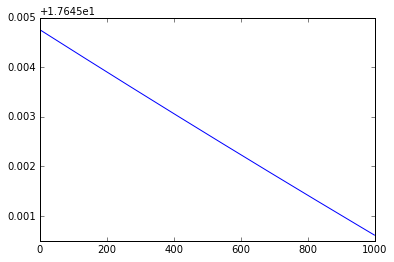

In [352]:
plot(losses)
losses

In [74]:
W=np.ones((4,4))
V=np.ones((4,1))*2

W[1]*V[0]


array([ 2.,  2.,  2.,  2.])

In [173]:
operator

NameError: name 'operator' is not defined